<a href="https://colab.research.google.com/github/zarah-ml/SDN-Traffic-Classification/blob/main/SDN_IoT_Traffic_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Traffic Classification in Software Defined Networking**

Traffic   classification   is   an   intelligent   process   which   categorizes  traffic  into  different classes.  Traffic classification with accuracy is of prime importance in network activities such as security monitoring, traffic engineering, fault detection, accounting of network usage, billing and for providing differentiation in Quality of Service (QoS) parameters of the various network services. ML based techniques include several steps. First, features are  extracted  by  calculating  over  multiple  packets  of  flows  (such as packet lengths, flow duration or inter-packet arrival times).  Then  features  are  refined  by  feature  selection  algorithms  if  possible.  Then  the  ML  model  is  trained  to  generate  classification  rules,  and  apply the  ML  algorithm  to classify  unknown  traffic  flows  using  previously  trained  ML  model.

In [29]:
import pandas as pd 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


##Dataset
The  dataset  contains  8  types  of  traffic - browsing,  chat,  audio-streaming, video-streaming, mail, VOIP, P2P and file transfer. The dataset contains 28 features including the label: 

*   inter-arrival  times(IAT)in  the  backward  and  forward  direction  (mean, min, max, std), the time is the time between two packets sent forward or backward. 
*   Flow  IAT  which  is  the  time  between  two  packets in  either  direction(mean,  min, max, std)
*  Idle time which is the time a flow was idle before becoming active(mean, min, max, std).
*  Active time, the time a flow was active before becoming idle (mean, max, min, std)
*  Flow bytes/s, flow packets/s and flow duration


In [3]:
df_data = pd.read_csv('/content/gdrive/MyDrive/TorCSV/CSV/Scenario-B/TimeBasedFeatures-10s-Layer2.csv')

In [4]:
df_data.shape

(8044, 29)

In [5]:
df_data.head()

,Source IP,Source Port,Destination IP,Destination Port,Protocol,Flow Duration,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,label
0,10.0.2.15,57188,82.161.239.177,110,6,7248168,2.112603e+04,29.110804,34515.085714,273869.262513,3897923,5,89483.555556,4.371676e+05,3898126,29,56614.039062,3.498551e+05,3898131,7,0,0,0,0,0,0,0,0,AUDIO
1,10.0.2.15,57188,82.161.239.177,110,6,5157723,1.052790e+03,3.683796,286540.166667,878838.525555,3743359,135,644715.375000,1.272066e+06,3743562,509,568901.666667,1.209110e+06,3743573,451,0,0,0,0,0,0,0,0,AUDIO
2,10.0.2.15,57188,82.161.239.177,110,6,41,1.324390e+07,48780.487805,41.000000,0.000000,41,41,41.000000,0.000000e+00,41,41,0.000000,0.000000e+00,0,0,0,0,0,0,0,0,0,0,AUDIO
3,10.0.2.15,57188,82.161.239.177,110,6,9543565,6.373855e+04,83.930900,11929.456250,90072.192523,2007954,5,31705.295681,1.455802e+05,2007978,28,19163.236948,1.141093e+05,2008877,5,0,0,0,0,0,0,0,0,AUDIO
4,10.0.2.15,57188,82.161.239.177,110,6,9987537,1.996166e+05,245.806348,4069.900978,20365.733229,608241,5,11743.344706,3.400857e+04,608450,31,6230.089208,2.533212e+04,608241,5,0,0,0,0,0,0,0,0,AUDIO


In [6]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8044 entries, 0 to 8043
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Source IP          8044 non-null   object 
 1    Source Port       8044 non-null   int64  
 2    Destination IP    8044 non-null   object 
 3    Destination Port  8044 non-null   int64  
 4    Protocol          8044 non-null   int64  
 5    Flow Duration     8044 non-null   int64  
 6    Flow Bytes/s      8044 non-null   float64
 7    Flow Packets/s    8044 non-null   float64
 8    Flow IAT Mean     8044 non-null   float64
 9    Flow IAT Std      8044 non-null   float64
 10   Flow IAT Max      8044 non-null   int64  
 11   Flow IAT Min      8044 non-null   int64  
 12  Fwd IAT Mean       8044 non-null   float64
 13   Fwd IAT Std       8044 non-null   float64
 14   Fwd IAT Max       8044 non-null   int64  
 15   Fwd IAT Min       8044 non-null   int64  
 16  Bwd IAT Mean       8044 

Since  ToR  datasets  have  the  same  source  and destination IPs, same source and destination ports and same protocols, we will be dropping these features leaving us with 23 time-based features.

In [7]:
data = df_data.drop(['Source IP',' Source Port',' Destination IP',' Destination Port', ' Protocol'], axis=1)

##Exploratory Data Analysis

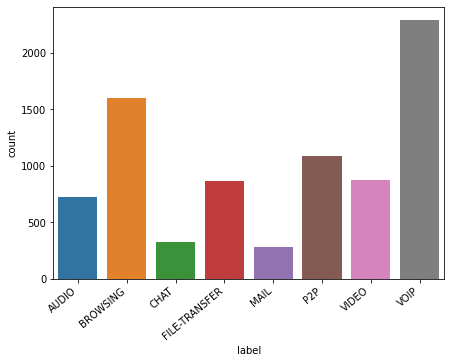

In [9]:
plt.figure(figsize = (7,5))
g = sns.countplot(data = data , x = 'label')
g.set_xticklabels(g.get_xticklabels(), rotation=40, ha="right")
plt.show()

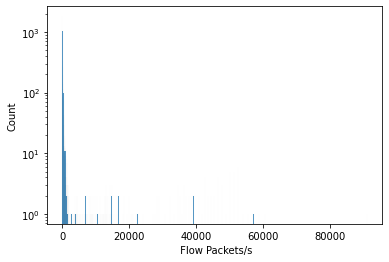

In [10]:
g = sns.histplot(data, x=' Flow Packets/s')
g.set_yscale('log')

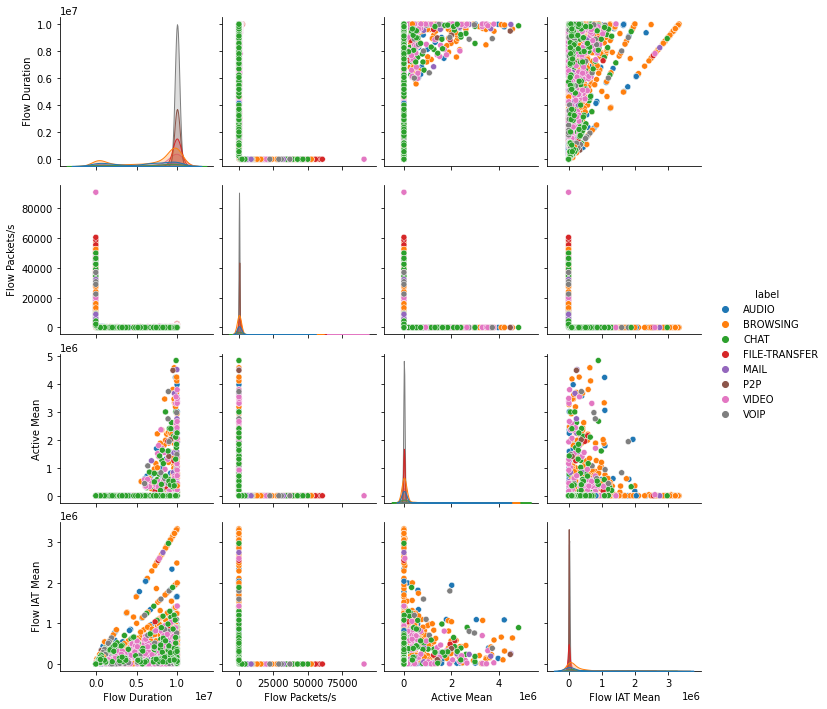

In [13]:
sns.pairplot(data, hue ='label', vars = [' Flow Duration', ' Flow Packets/s','Active Mean',' Flow IAT Mean'])

In [11]:
label_transform = LabelEncoder()
data['label'] = label_transform.fit_transform(data['label'])
data['label'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7])

In [12]:
X = data.drop('label', axis=1)
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=11)

In [13]:
# determine categorical and numerical columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
numerical_cols

Index([' Flow Duration', ' Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean',
       ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Mean',
       ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Mean',
       ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Active Mean',
       ' Active Std', ' Active Max', ' Active Min', 'Idle Mean', ' Idle Std',
       ' Idle Max', ' Idle Min'],
      dtype='object')

In [15]:
t = [('scale', StandardScaler(), numerical_cols)]

col_trans = ColumnTransformer(transformers=t)

# fit the transformation on training data
col_trans.fit(X_train)

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('scale',
                                 StandardScaler(copy=True, with_mean=True,
                                                with_std=True),
                                 Index([' Flow Duration', ' Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean',
       ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Mean',
       ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Mean',
       ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Active Mean',
       ' Active Std', ' Active Max', ' Active Min', 'Idle Mean', ' Idle Std',
       ' Idle Max', ' Idle Min'],
      dtype='object'))],
                  verbose=False)

In [16]:
X_train_transform = col_trans.transform(X_train)
X_test_transform = col_trans.transform(X_test)

In [16]:
def classifier(model, X_train,y_train, X_test, y_test):
  model.fit(X_train, y_train)
  pred_attack = model.predict(X_test)
  print(f'Name model: {model}')
  print(classification_report(y_test,pred_attack))
  fig, ax = plt.subplots(figsize=(12, 8))
  cm = confusion_matrix(y_test,pred_attack)
  cmp = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
  cmp.plot(ax=ax)

  plt.show();

  accuracy = accuracy_score(y_test,pred_attack)

  return  accuracy

Name model: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
              precision    recall  f1-score   support

           0       0.77      0.71      0.74       145
           1       0.68      0.85      0.76       336
           2       0.61      0.27      0.37        64
           3       0.94      0.91      0.92       182
           4       0.70      0.39      0.50        49
           5       0.98      0.98      0.98       214
           6       0.76      0.73      0.74       169
        

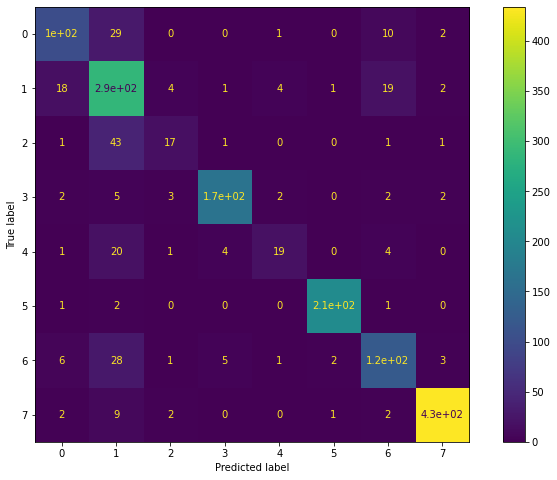

Name model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
              precision    recall  f1-score   support

           0       0.78      0.75      0.77       145
           1       0.65      0.85      0.74       336
           2       0.58      0.22      0.32        64
           3       0.88      0.86      0.87       182
           4       0.74      0.29      0.41        49
           5       0.96      0.94      0.95       214
           6       0.68      0.67      0.68       169
           7       0.99      0.96      0.97       450

    accuracy                   

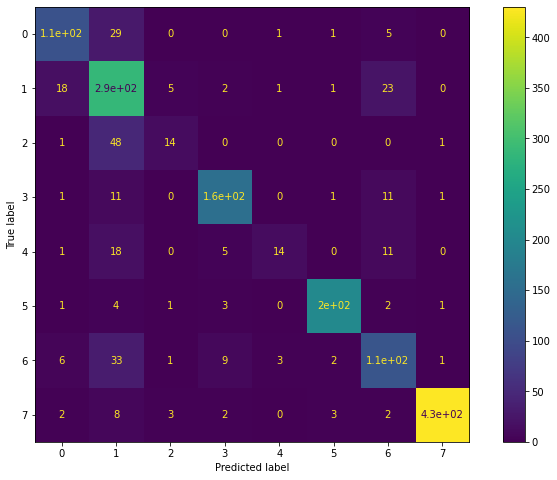

Name model: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
              precision    recall  f1-score   support

           0       0.62      0.69      0.66       145
           1       0.57      0.71      0.63       336
           2       0.34      0.16      0.22        64
           3       0.67      0.70      0.69       182
           4       0.48      0.33      0.39        49
           5       0.87      0.93      0.90       214
           6       0.50      0.34      0.41       169
           7       0.98      0.95      0.96       450

    accuracy                           0.73      1609
   macro avg       0.63      0.60      0.61      1609
weighted avg       0.72      0.73      0.72      1609



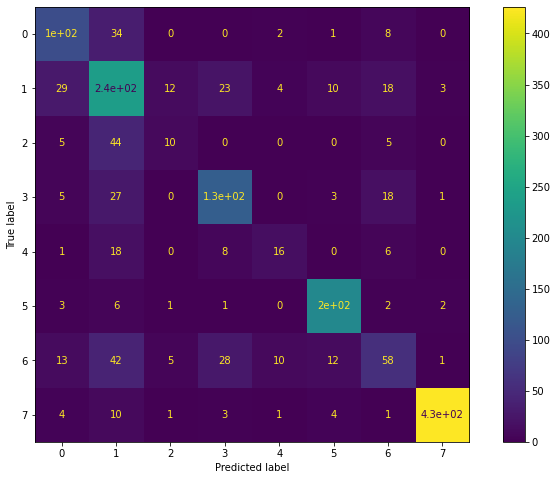

Name model: GaussianNB(priors=None, var_smoothing=1e-09)
              precision    recall  f1-score   support

           0       0.34      0.18      0.23       145
           1       0.60      0.01      0.02       336
           2       0.13      0.17      0.15        64
           3       0.01      0.01      0.01       182
           4       0.07      0.27      0.11        49
           5       0.19      0.98      0.33       214
           6       0.10      0.03      0.05       169
           7       0.02      0.00      0.00       450

    accuracy                           0.17      1609
   macro avg       0.18      0.21      0.11      1609
weighted avg       0.21      0.17      0.08      1609



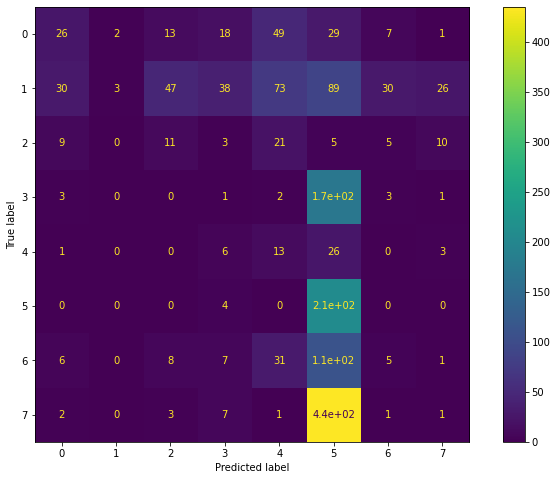

In [17]:
fprs = []
tprs = []
roc_aucs = []
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

model = [RandomForestClassifier(), XGBClassifier(), KNeighborsClassifier(), GaussianNB() ]
for m in  model:
  accuracy = classifier(m,X_train,y_train, X_test, y_test) 
  accuracy_list.append(accuracy)
  

In [20]:
models = ['RandomForestClassifier', 'XGBClassifier', 'KNeighborsClassifier', 'GaussianNB']
results_dict = {'Model Name': models,
                'Accuracy': accuracy_list}
              
results_df = pd.DataFrame(results_dict)

# sort the results according to F1 score on testing data
results_df

,Model Name,Accuracy
0,RandomForestClassifier,0.844624
1,XGBClassifier,0.824114
2,KNeighborsClassifier,0.729646
3,GaussianNB,0.167806


##Feature Selection
The    quality    of    the    feature    is    significant    to    the performance  of  ML  algorithm.  Using  redundant  features often  reduces  the  accuracy  of  most  ML  algorithms,  whichcan   also   increase   the   system   computationally   cost. Consequently it is important to select optimal set of features to characterize  different  types  of  traffic  which  describes  essential  information  about  the  classes  of  interest.  Feature  selection  algorithms  can  be  divided  into  filter  method  or  wrapper  method. 

In [21]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [24]:
#Define Sequential Forward Selection (sfs)
sffs = SFS(RandomForestClassifier(),
           k_features=13,
           forward=True,
           floating=False,
           scoring='accuracy',
           cv=2)
#Use SFS to select the top 5 features 
feature_names = numerical_cols
sffs.fit(X_train, y_train)

#Create a dataframe for the SFS results 
df_SFFS_results = pd.DataFrame(sffs.subsets_).transpose()

,feature_idx,cv_scores,avg_score,feature_names
1,"(1,)","[0.5034182722187694, 0.5026422132421511]",0.50303,"( Flow Bytes/s,)"
2,"(1, 7)","[0.735550031075202, 0.737332918868511]",0.736441,"( Flow Bytes/s, Fwd IAT Mean)"
3,"(1, 7, 11)","[0.7902423865755127, 0.7817842710599938]",0.786013,"( Flow Bytes/s, Fwd IAT Mean, Bwd IAT Mean)"
4,"(1, 7, 11, 12)","[0.8151025481665631, 0.804165371464097]",0.809634,"( Flow Bytes/s, Fwd IAT Mean, Bwd IAT Mean, B..."
5,"(1, 7, 10, 11, 12)","[0.8222498446239901, 0.812247435498912]",0.817249,"( Flow Bytes/s, Fwd IAT Mean, Fwd IAT Min, Bw..."
6,"(1, 6, 7, 10, 11, 12)","[0.8281541330018645, 0.8187752564501088]",0.823465,"( Flow Bytes/s, Flow IAT Min, Fwd IAT Mean, ..."
7,"(0, 1, 6, 7, 10, 11, 12)","[0.829397141081417, 0.82312713708424]",0.826262,"( Flow Duration, Flow Bytes/s, Flow IAT Min,..."
8,"(0, 1, 6, 7, 10, 11, 12, 14)","[0.8297078931013051, 0.8256139260180292]",0.827661,"( Flow Duration, Flow Bytes/s, Flow IAT Min,..."
9,"(0, 1, 6, 7, 8, 10, 11, 12, 14)","[0.8359229334990678, 0.8259247746347529]",0.830924,"( Flow Duration, Flow Bytes/s, Flow IAT Min,..."
10,"(0, 1, 6, 7, 8, 10, 11, 12, 13, 14)","[0.8359229334990678, 0.8277898663350948]",0.831856,"( Flow Duration, Flow Bytes/s, Flow IAT Min,..."


In [29]:
df_SFFS_results.feature_names[10]

(' Flow Duration',
 ' Flow Bytes/s',
 ' Flow IAT Min',
 'Fwd IAT Mean',
 ' Fwd IAT Std',
 ' Fwd IAT Min',
 'Bwd IAT Mean',
 ' Bwd IAT Std',
 ' Bwd IAT Max',
 ' Bwd IAT Min')

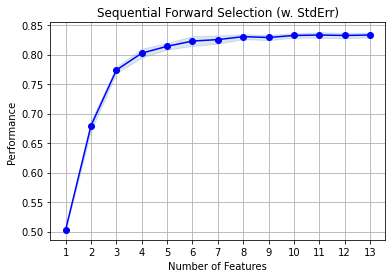

In [36]:
fig = plot_sfs(sffs.get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [45]:
sfsgb = SFS(GradientBoostingClassifier(),
           k_features=13,
           forward=True,
           floating=False,
           scoring='accuracy',
           cv=2)
#Use SFS to select the top 5 features 
feature_names = numerical_cols
sfsgb.fit(X_train, y_train)

#Create a dataframe for the SFS results 
df_SFFS_results = pd.DataFrame(sfsgb.subsets_).transpose()
df_SFFS_results

,feature_idx,cv_scores,avg_score,feature_names
1,"(1,)","[0.6143567433188316, 0.5977618899595897]",0.606059,"( Flow Bytes/s,)"
2,"(1, 7)","[0.7318210068365444, 0.7224121852657756]",0.727117,"( Flow Bytes/s, Fwd IAT Mean)"
3,"(1, 7, 14)","[0.7750155376009944, 0.764376748523469]",0.769696,"( Flow Bytes/s, Fwd IAT Mean, Bwd IAT Min)"
4,"(1, 7, 13, 14)","[0.800497203231821, 0.7901771837115324]",0.795337,"( Flow Bytes/s, Fwd IAT Mean, Bwd IAT Max, B..."
5,"(1, 7, 11, 13, 14)","[0.8132380360472343, 0.8013677339135841]",0.807303,"( Flow Bytes/s, Fwd IAT Mean, Bwd IAT Mean, B..."
6,"(1, 7, 10, 11, 13, 14)","[0.8169670602858918, 0.812247435498912]",0.814607,"( Flow Bytes/s, Fwd IAT Mean, Fwd IAT Min, Bw..."
7,"(1, 6, 7, 10, 11, 13, 14)","[0.8219390926041019, 0.8178427105999378]",0.819891,"( Flow Bytes/s, Flow IAT Min, Fwd IAT Mean, ..."
8,"(1, 6, 7, 10, 11, 13, 14, 17)","[0.8247358607830951, 0.8169101647497669]",0.820823,"( Flow Bytes/s, Flow IAT Min, Fwd IAT Mean, ..."
9,"(1, 6, 7, 9, 10, 11, 13, 14, 17)","[0.8238036047234307, 0.8193969536835561]",0.8216,"( Flow Bytes/s, Flow IAT Min, Fwd IAT Mean, ..."
10,"(1, 6, 7, 9, 10, 11, 13, 14, 17, 18)","[0.8272218769422002, 0.8197078023002797]",0.823465,"( Flow Bytes/s, Flow IAT Min, Fwd IAT Mean, ..."


In [30]:
df_SFFS_results.feature_names[10]

(' Flow Duration',
 ' Flow Bytes/s',
 ' Flow IAT Min',
 'Fwd IAT Mean',
 ' Fwd IAT Std',
 ' Fwd IAT Min',
 'Bwd IAT Mean',
 ' Bwd IAT Std',
 ' Bwd IAT Max',
 ' Bwd IAT Min')

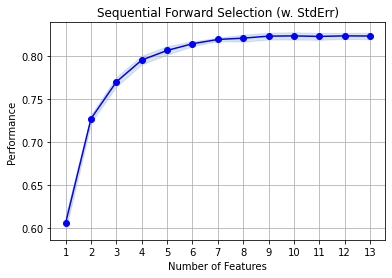

In [38]:
fig = plot_sfs(sfsgb.get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [17]:
!pip install shap
import shap

     |████████████████████████████████| 358kB 25.8MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491613 sha256=742e385094de22a2aff83e42526ed19b7e2f4aeb9c0630fa58c2beaaa58c0b87
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [18]:
model = RandomForestClassifier()
model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [19]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

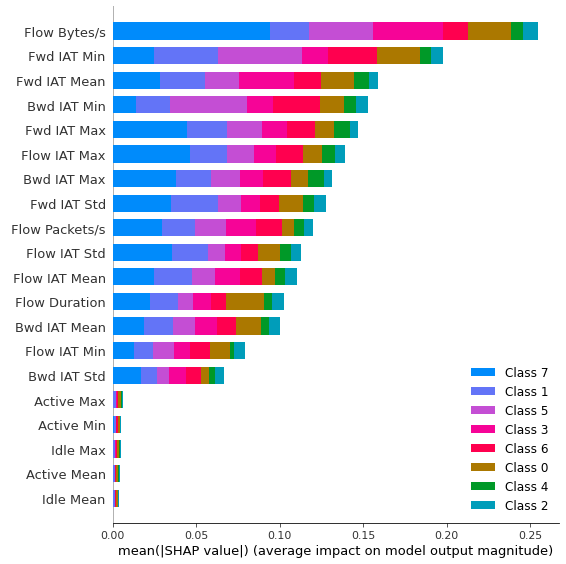

In [37]:
shap.summary_plot(shap_values, features=X_train, feature_names=numerical_cols, plot_type= 'bar')

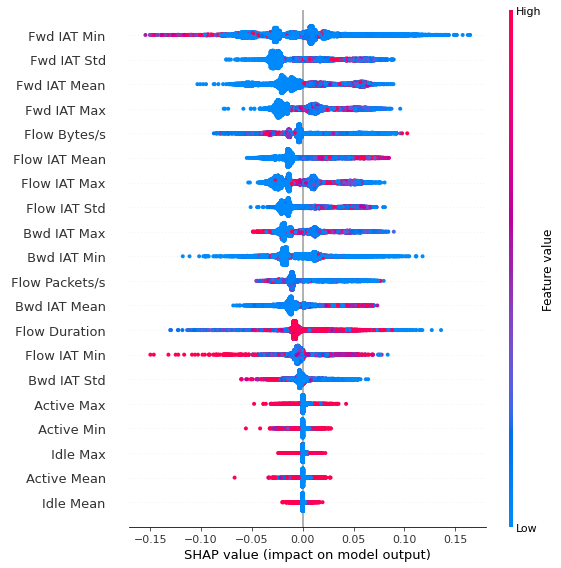

In [41]:
shap.summary_plot(shap_values[1],X_train)

In [29]:
model_XGB = XGBClassifier()
model_XGB.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [32]:
explainer = shap.TreeExplainer(model_XGB)
shap_values = explainer.shap_values(X_train)

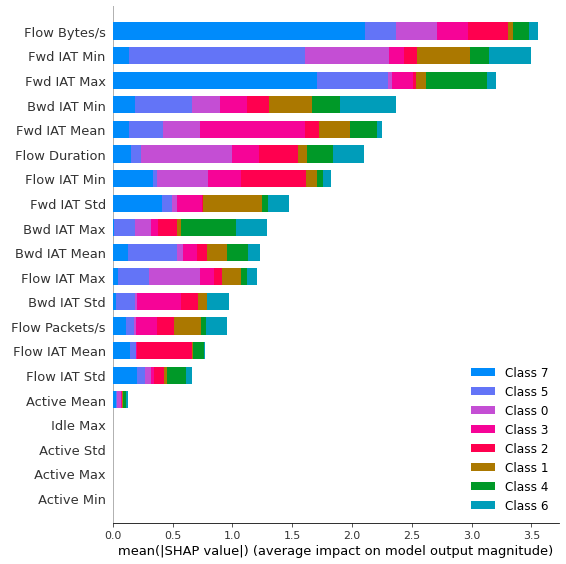

In [33]:
shap.summary_plot(shap_values, features=X_train, feature_names=numerical_cols, plot_type= 'bar')

In [37]:
# Top 10 Important Features for RandomForest classsifier using SPS
X_imp_RF_sfs = [' Flow Duration', ' Flow Bytes/s', ' Flow IAT Min', 'Fwd IAT Mean',
                       ' Fwd IAT Std', ' Fwd IAT Min', 'Bwd IAT Mean',' Bwd IAT Std',
                        ' Bwd IAT Max',  ' Bwd IAT Min']
X = X_train[X_imp_RF_sfs]
X_test = X_test[X_imp_RF_sfs]

In [38]:
model = RandomForestClassifier()
model.fit(X,y_train)
pred_attack = model.predict(X_test)
accuracy = accuracy_score(y_test,pred_attack)
print(accuracy)

0.8464885021752642


In [28]:
X_imp_RF_shap = [' Flow Bytes/s',' Fwd IAT Min',' Fwd IAT Max',' Flow IAT Max','Fwd IAT Mean',' Bwd IAT Min', ' Bwd IAT Max', ' Flow Duration',' Flow IAT Std', ' Fwd IAT Std']
X = X_train[X_imp_RF_shap]
X_test = X_test[X_imp_RF_shap]

KeyError: ignored

In [23]:
model = XGBClassifier()
model.fit(X,y_train)
pred_attack = model.predict(X_test)
accuracy = accuracy_score(y_test,pred_attack)
print(accuracy)

0.8104412678682411
